In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import random
import gym
from IPython import display as ipythondisplay
import time


In [2]:
def plot(episode, scores, average_scores, current_step, i=True):
    is_ipython = 'inline' in matplotlib.get_backend()
    if is_ipython:
        ipythondisplay.clear_output(wait=True)
    if i:
        plt.xlabel("Episodes")
        plt.ylabel("Scores")
        plt.title('Training...')
        plt.plot(scores, label='Scores')
        # plot average score
        plt.plot(average_scores, label='Average')
        plt.legend()
        plt.grid()
        plt.pause(0.001)
        plt.show()
        print("Episode: {} - Current step: {} - Score: {} - Average score: {} - Record: {}".format(episode, current_step, scores[-1], round(average_scores[-1], 2), max(scores)))
    else: print("Episode: {} - Current step: {} - Score: {} - Average score: {} - Record: {}".format(episode, current_step, scores[-1], round(average_scores[-1], 2), max(scores)))

def get_average_scores(scores, num):
    if len(scores) > num:
        return np.average(scores[-num:])
    else:
        return np.average(scores)


In [3]:
env = gym.make("CartPole-v1")
episodes = 10
scores = []
for episode in range(1, episodes + 1):
    state = env.reset()
    score = 0
    done = False

    while not done:
        action = env.action_space.sample()
        n_state, reward, done, _ = env.step(action)
        score += reward
        state = n_state
    scores.append(score)

env.close()


In [4]:
class ReplayMemory:
    def __init__(self, batch_size, capacity):
        self.memory = []
        self.batch_size = batch_size
        self.capacity = capacity
        self.count = 0

    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.count % self.capacity] = experience
        self.count += 1

    def sample(self):
        return random.sample(self.memory, self.batch_size)

    def can_provide_sample(self):
        return len(self.memory) >= self.batch_size

    def extract(self, experiences):
        experiences = np.array(experiences, dtype=object)
        state = [[j for j in i] for i in experiences[:, 0]]
        action = experiences[:, 1]
        n_state = [[j for j in i] for i in experiences[:, 2]]
        reward = experiences[:, 3]
        done = experiences[:, 4]
        return state, action, n_state, reward, done


In [5]:
class DQN:
    def __init__(self, batch_size, state_shape, action_size, learning_rate=0.001):
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.model = Sequential()
        self.model.add(Dense(24, input_shape=state_shape, activation='relu'))
        self.model.add(Dense(24, activation='relu'))
        self.model.add(Dense(action_size, activation='linear'))
        self.model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))

    def predict(self, state):
        return self.model.predict(state, verbose=0)

    def fit(self, state, target):
        self.model.fit(state, target, epochs=5, verbose=0)

    def copy_weights(self, target_network, tau=1):
        # copy weights from target_network to self.model with a factor of tau
        weights = target_network.model.get_weights()
        self.model.set_weights([(1 - tau) * w + tau * w_target for w, w_target in zip(weights, self.model.get_weights())])
        # self.model.set_weights(target_network.model.get_weights())


In [6]:
class EpsilonGreedyStrategy:
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay

    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * np.exp(-1. * current_step * self.decay)


In [7]:
class Agent:
    def __init__(self, state_shape, num_actions, batch_size, memory_size, gamma, start=1, end=0.01, decay=0.001, learning_rate=0.001):
        self.current_step = 0
        self.gamma = gamma
        self.strategy = EpsilonGreedyStrategy(start, end, decay)
        self.memory = ReplayMemory(batch_size, memory_size)
        self.num_actions = num_actions
        self.policy_network = DQN(batch_size, state_shape, num_actions, learning_rate)
        self.target_network = DQN(batch_size, state_shape, num_actions, learning_rate)
        self.target_network.copy_weights(self.policy_network)

    def select_action(self, state, isLearn=True):
        rate = self.strategy.get_exploration_rate(self.current_step)
        self.current_step += 1
        if isLearn and rate > random.random():
            return random.randrange(self.num_actions)
        else:
            return np.argmax(self.policy_network.predict(state))

    def update_target(self, tau=1):
        self.target_network.copy_weights(self.policy_network, tau)

    def memorize(self, experience):
        self.memory.push(experience)

    def learn(self):
        if self.memory.can_provide_sample():
            experiences = self.memory.sample()
            state, action, n_state, reward, done = self.memory.extract(experiences)
            target = self.policy_network.predict(np.asarray(state))
            next_target_q = self.target_network.predict(np.asarray(n_state))
            next_policy_q = self.policy_network.predict(np.asarray(n_state))
            next_action = np.argmax(next_policy_q, axis=1)
            print(next_action)
            
            time.sleep(2)

            i = -1
            for action in next_action:
                i += 1
                if done[i]: 
                    target[i,:] = reward[i]
                    continue
                target[i][action] = next_target_q[i][action]*self.gamma + reward[i]

            self.policy_network.fit(np.asarray(state), np.asarray(target))
    
    def save_model(self, filename):
        self.policy_network.model.save_weights(filename)

    def load_model(self, filename):
        self.policy_network.model.load_weights(filename)
        self.update_target()

In [8]:
agent = Agent(state_shape=env.observation_space.shape, num_actions=2, batch_size=256, memory_size=10000, gamma=0.95, end=0.02)
update_target = 20
scores = []
tf.config.list_physical_devices('CPU')
average_scores = []
episode = 0

2022-06-14 14:48:58.170837: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


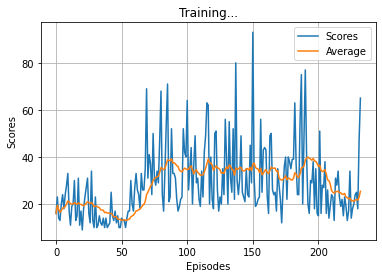

Episode: 234 - Current step: 6672 - Score: 65.0 - Average score: 25.45 - Record: 93.0
Exploration rate 2.1240547198840125 %


In [9]:
episodes = 300
saved = True
win = 0
for eps in range(episode + 1, episodes + episode):
    episode += 1
    state = env.reset()
    score = 0
    done = False

    if eps > 1: plot(eps, scores, average_scores, agent.current_step)
    if eps > 1: print("Exploration rate", agent.strategy.get_exploration_rate(agent.current_step) * 100, "%")
    if not saved: print("Agent has won at episode", win)
    
    while not done:
        env.render()
        action = agent.select_action(np.expand_dims(state, 0))
        n_state, reward, done, _ = env.step(action)
        score += reward
        experience = (state, action, n_state, reward, done)
        agent.memorize(experience)
        state = n_state
    
    scores.append(score)
    average_scores.append(get_average_scores(scores, 20))
    
    agent.learn()

    if eps % update_target == 0:
        agent.update_target()

    if saved and score > 499:
        win = eps
        saved = False

# print(agent.predict)
env.close()

In [ ]:
state = env.reset()
done = False
score = 0
while not done:
    env.render()
    action = agent.select_action(np.expand_dims(state, 0), False)
    state, reward, done, _ = env.step(action)
    score += reward

print("Score: {}".format(score))
env.close()

Score: 9.0
